In [1]:
import scanpy as sc
import pandas as pd
import scipy.io

# Step 1: Load the barcodes
barcodes = pd.read_csv('GSM5008737_RNA_3P-barcodes.tsv.gz', header=None, sep="\t")
barcodes = barcodes[0].values  # If the file has a single column with the barcode information

# Step 2: Load the gene expression matrix (assuming it's in a matrix format like .mtx or other)
# For example, let's assume you have a .mtx file, otherwise you would need to replace with the appropriate file path
expression_matrix = scipy.io.mmread('GSM5008737_RNA_3P-matrix.mtx.gz').T  # Transpose if necessary

# Step 3: Load the feature (gene) information
features = pd.read_csv('GSM5008737_RNA_3P-features.tsv.gz', header=None, sep="\t")
genes = features[0].values  # Assuming gene names are in the first column

# Step 4: Load any annotations (e.g., TCRab annotations)
#annotations = pd.read_csv('/mnt/data/GSM5008743_TCRab_batch1_annotations.csv.gz')

# Step 5: Create the AnnData object
adata = sc.AnnData(X=expression_matrix)

# Add feature (gene) names
adata.var_names = genes

# Add cell barcodes to observation names
adata.obs_names = barcodes

# Step 5: Load metadata and integrate it into AnnData
metadata = pd.read_csv('GSE164378_sc.meta.data_3P.csv')

# Ensure the metadata aligns with barcodes
metadata = metadata.rename(columns={'Unnamed: 0': 'cell_barcode'})  # Rename for clarity
metadata = metadata.set_index('cell_barcode')  # Set barcodes as index

# Subset metadata to match barcodes in `adata.obs_names`
metadata = metadata.loc[adata.obs_names]

# Add metadata to AnnData
adata.obs = metadata
# Step 6: Add annotations to .obs if needed
# For example, assuming the annotation file contains metadata like 'cell_type'
# This could be specific depending on what the annotation file contains
#adata.obs['cell_type'] = annotations['cell_type']  # Replace 'cell_type' with the actual column name in your annotation file

# Step 7: Optionally inspect the AnnData object
print(adata)


AnnData object with n_obs × n_vars = 161764 × 33538
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch'


In [2]:
metadata = pd.read_csv('GSE164378_sc.meta.data_3P.csv')
print(metadata.head())  # Display the first few rows
print(metadata.columns)  # Display the column names

            Unnamed: 0  nCount_ADT  nFeature_ADT  nCount_RNA  nFeature_RNA  \
0  L1_AAACCCAAGAAACTCA        7535           217       10823          2915   
1  L1_AAACCCAAGACATACA        6013           209        5864          1617   
2  L1_AAACCCACAACTGGTT        6620           213        5067          1381   
3  L1_AAACCCACACGTACTA        3567           202        4786          1890   
4  L1_AAACCCACAGCATACT        6402           215        6505          1621   

      orig.ident lane donor  time celltype.l1 celltype.l2 celltype.l3 Phase  \
0  SeuratProject   L1    P2     7        Mono   CD14 Mono   CD14 Mono    G1   
1  SeuratProject   L1    P1     7       CD4 T     CD4 TCM   CD4 TCM_1    G1   
2  SeuratProject   L1    P4     2       CD8 T   CD8 Naive   CD8 Naive     S   
3  SeuratProject   L1    P3     7          NK          NK        NK_2    G1   
4  SeuratProject   L1    P4     7       CD8 T   CD8 Naive   CD8 Naive    G1   

    Batch  
0  Batch1  
1  Batch1  
2  Batch1  
3  Batch

In [3]:
# View the tail of the AnnData object
print("\nLast few observations (cells):")
print(adata.obs.tail())  # View the last few cells

print("\nLast few variables (genes):")
print(adata.var.tail())  # View the last few genes


Last few observations (cells):
                       nCount_ADT  nFeature_ADT  nCount_RNA  nFeature_RNA  \
E2L8_TTTGTTGGTCGTGATT        4170           197        9346          2201   
E2L8_TTTGTTGGTGTGCCTG        6927           209        9318          2938   
E2L8_TTTGTTGGTTAGTTCG        4222           206       11619          3224   
E2L8_TTTGTTGGTTGGCTAT        6063           217       15436          3999   
E2L8_TTTGTTGTCTCATGGA        4266           210       11892          3330   

                          orig.ident  lane donor  time celltype.l1  \
E2L8_TTTGTTGGTCGTGATT  SeuratProject  E2L8    P5     7       CD8 T   
E2L8_TTTGTTGGTGTGCCTG  SeuratProject  E2L8    P5     2        Mono   
E2L8_TTTGTTGGTTAGTTCG  SeuratProject  E2L8    P8     0           B   
E2L8_TTTGTTGGTTGGCTAT  SeuratProject  E2L8    P5     2        Mono   
E2L8_TTTGTTGTCTCATGGA  SeuratProject  E2L8    P5     7        Mono   

                          celltype.l2           celltype.l3 Phase   Batch  
E2L8_TTT

In [5]:
# Check which gene names are duplicated
duplicated_genes = adata.var_names[adata.var_names.duplicated()]

# Print the duplicated gene names
print(duplicated_genes)

Index([], dtype='object')


In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


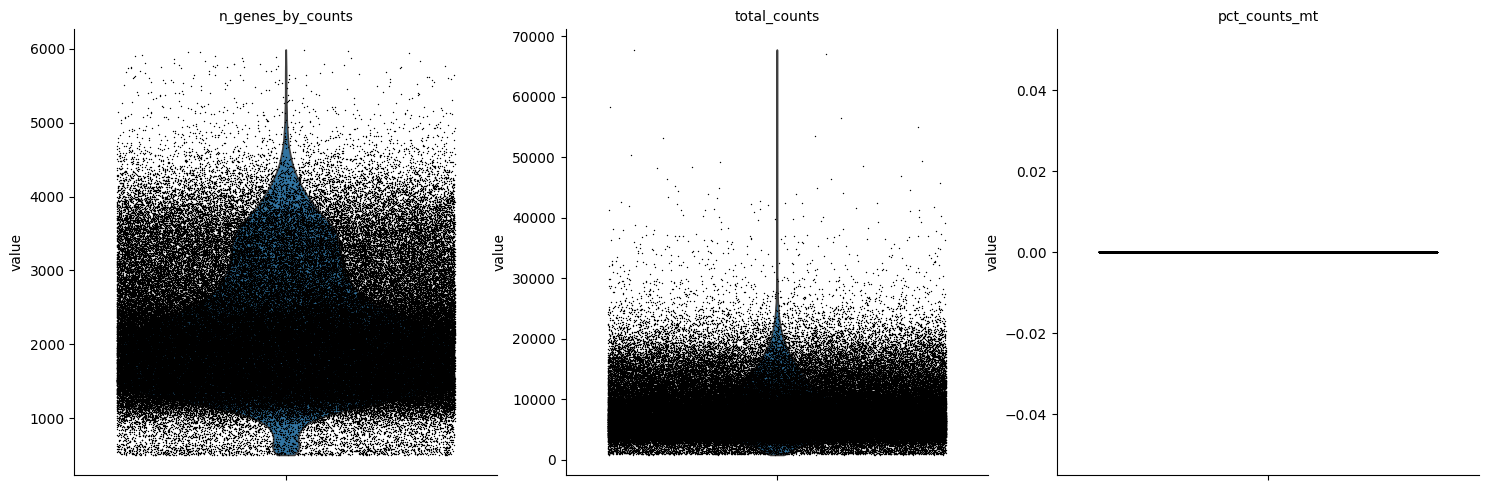

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

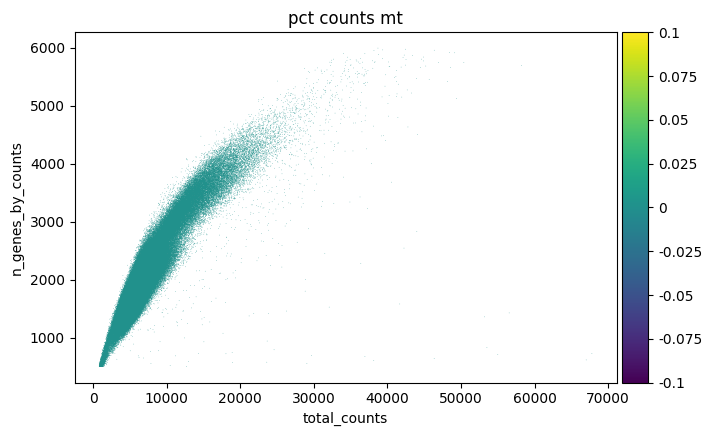

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
from scipy.sparse import csr_matrix

# Ensure the data matrix is in CSR format (suitable for subsetting)
if isinstance(adata.X, csr_matrix):
    pass  # No conversion needed if it's already in CSR format
else:
    adata.X = csr_matrix(adata.X)  # Convert to CSR format if it's not

# Now you can filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
import skimage
sc.pp.scrublet(adata)

: 

: 

In [9]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [10]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)

In [11]:
adata.write('/Volumes/Seagate/normalized_data.h5ad')



In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

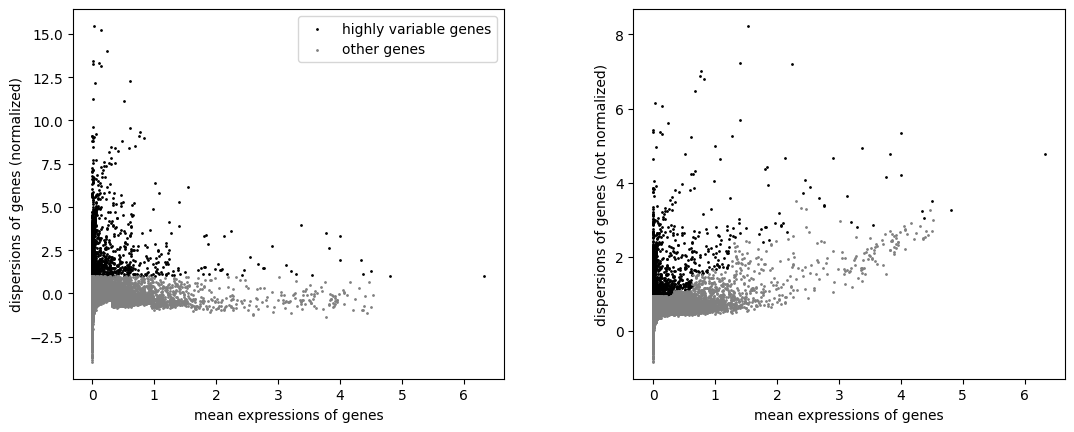

In [13]:
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var['highly_variable']]

In [15]:
sc.tl.pca(adata, n_comps = 50)

/Users/coryhenn/Documents/Big_Data/BigDataTeamProject/bigDataGroupProject/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


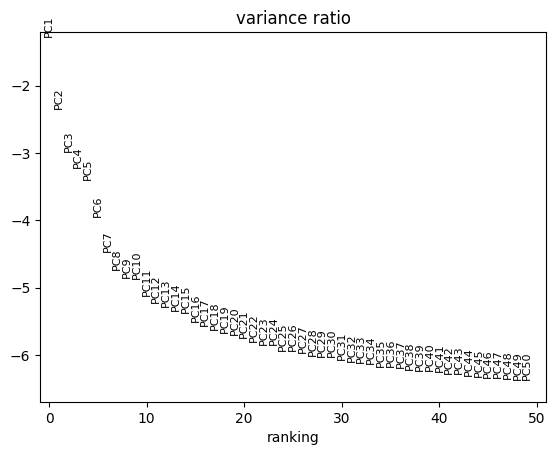

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

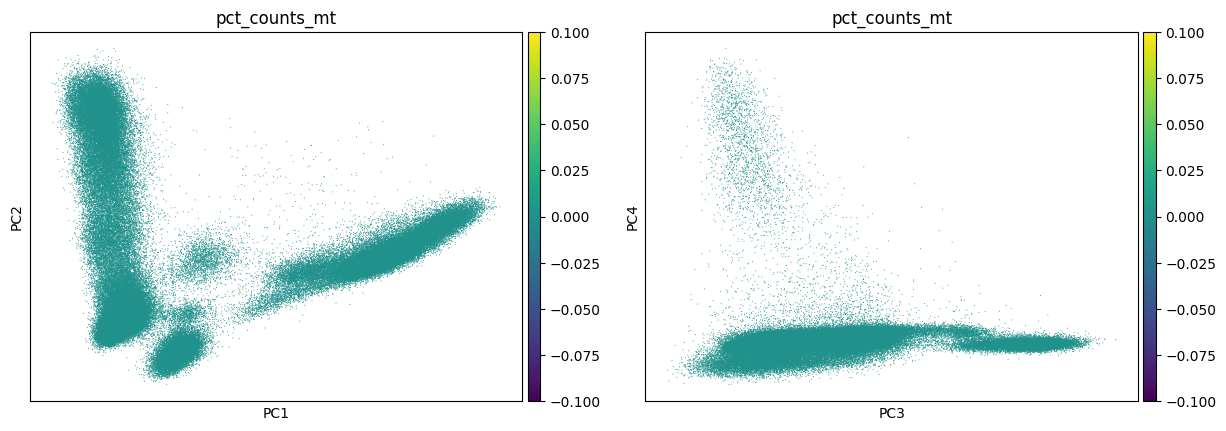

In [17]:
sc.pl.pca(
    adata,
    color=["pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [18]:
sc.pp.neighbors(adata)

/Users/coryhenn/Documents/Big_Data/BigDataTeamProject/bigDataGroupProject/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
sc.tl.umap(adata)

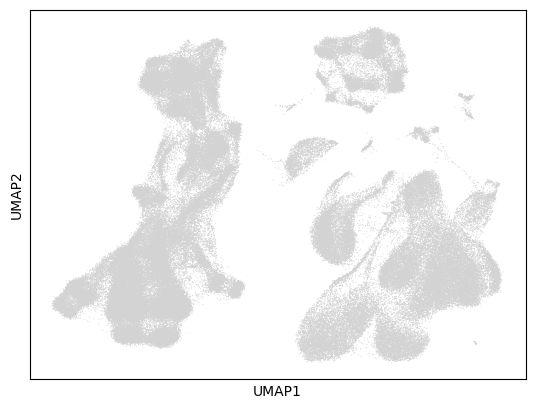

In [20]:
sc.pl.umap(
    adata,
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [21]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

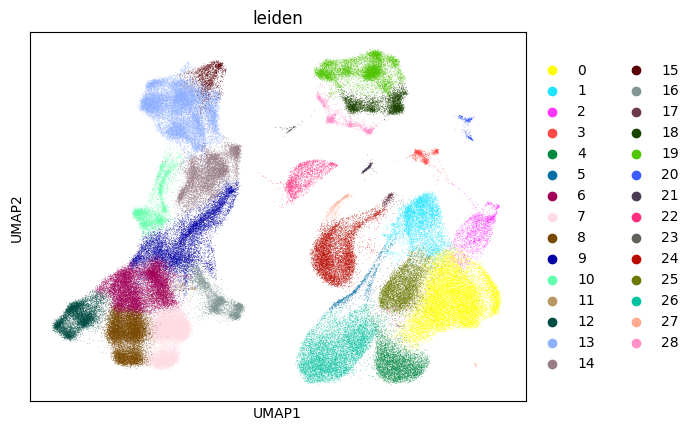

In [22]:
sc.pl.umap(adata, color=["leiden"])

KeyError: 'Could not find key predicted_doublet in .var_names or .obs.columns.'

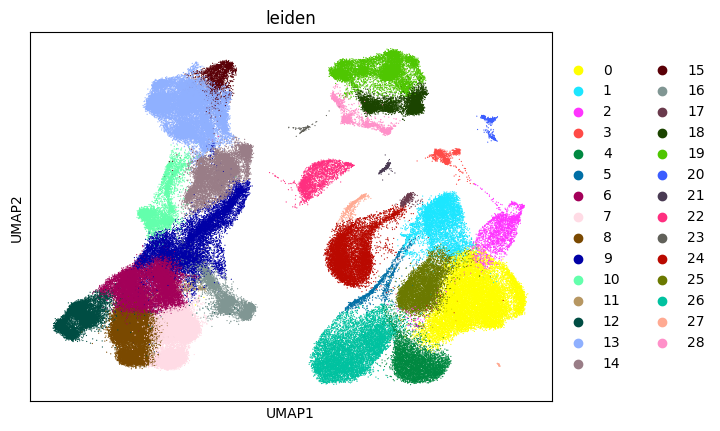

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

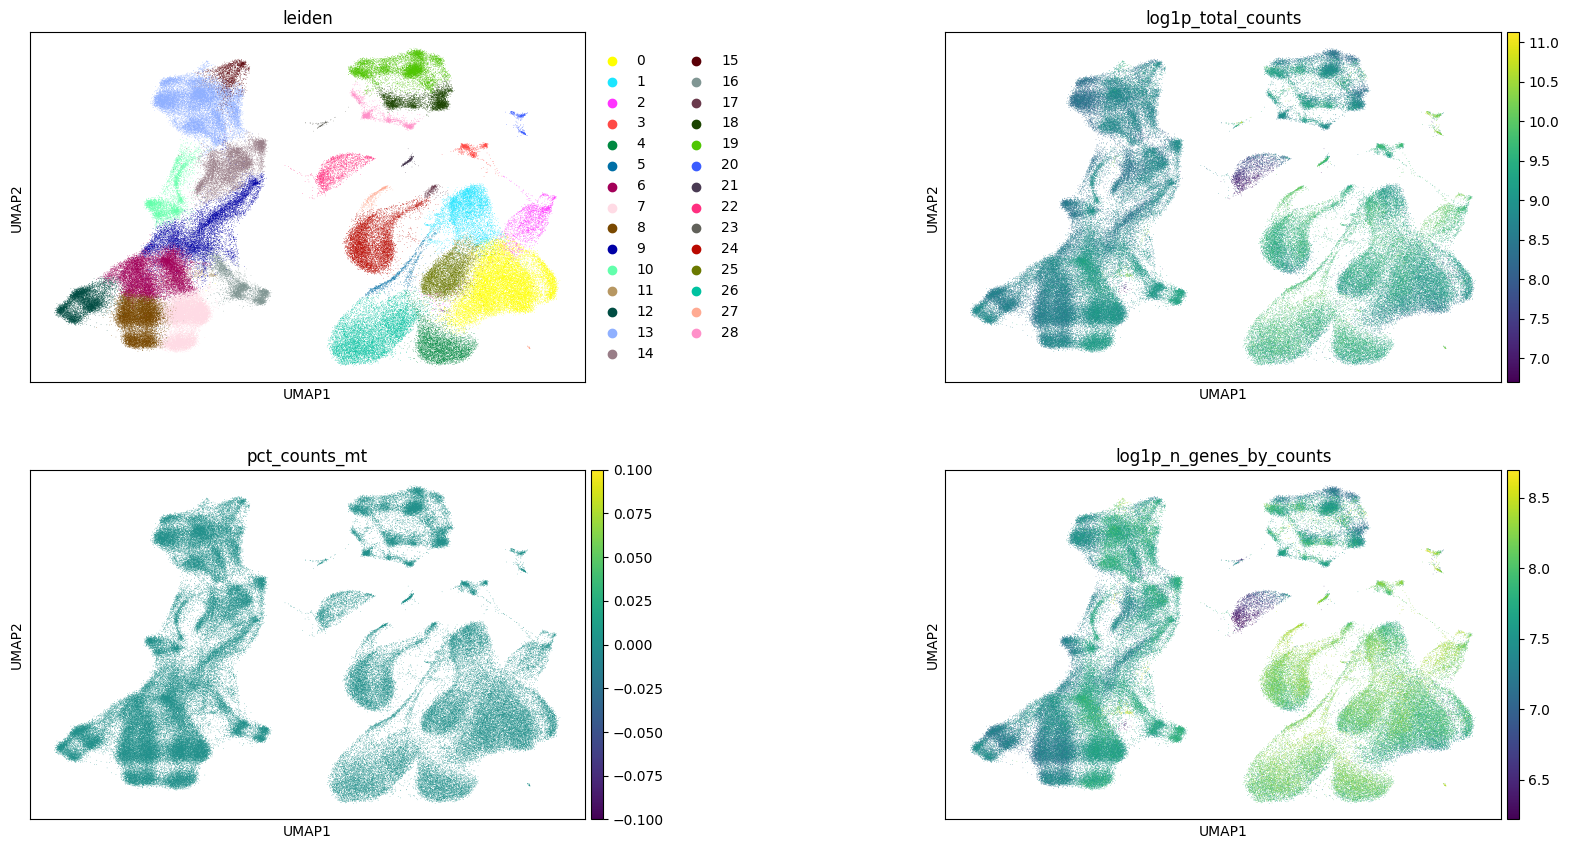

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [55]:
for res in [0.2, 0.5, 1.00]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

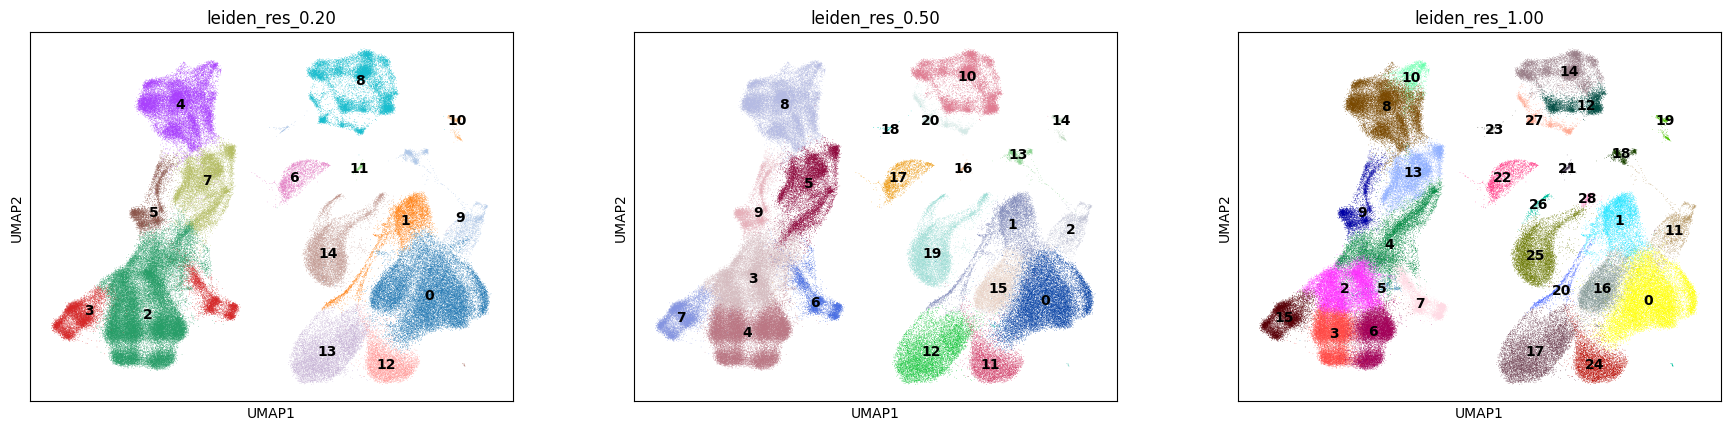

In [57]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.20", "leiden_res_0.50", "leiden_res_1.00"],
    legend_loc="on data",
)

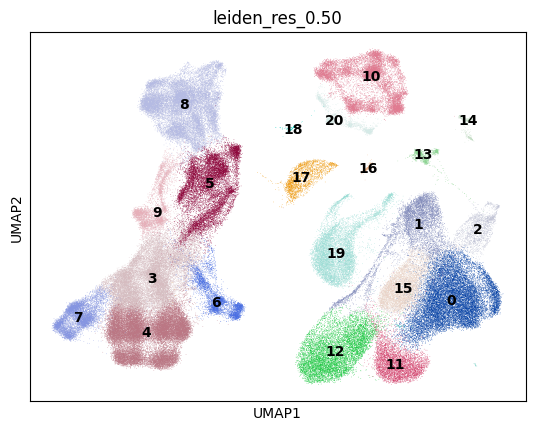

In [67]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.50"],
    legend_loc="on data",
)

In [69]:
sc.tl.rank_genes_groups(adata, groupby='leiden_res_0.50', method='wilcoxon')
print(adata.obs['leiden_res_0.50'].unique())


['0', '3', '4', '8', '5', ..., '15', '12', '19', '6', '20']
Length: 21
Categories (21, object): ['0', '1', '2', '3', ..., '17', '18', '19', '20']


/Users/coryhenn/Documents/Big_Data/BigDataTeamProject/bigDataGroupProject/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/coryhenn/Documents/Big_Data/BigDataTeamProject/bigDataGroupProject/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/coryhenn/Documents/Big_Dat

In [70]:
print(adata.uns['rank_genes_groups'].keys())


dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])


In [71]:
top_genes_per_cluster = pd.DataFrame({
    cluster: adata.uns['rank_genes_groups']['names'][cluster]
    for cluster in adata.obs['leiden_res_0.50'].unique()
})

In [72]:
# Save cluster information to CSV
top_genes_per_cluster.to_csv("PBMC_clusters_gene_info_.csv", header=True, index=True)

In [73]:
import pandas as pd

# Get the cluster assignments
clusters = adata.obs['leiden_res_0.50']  # Assuming 'leiden_res_0.50' contains the cluster assignments

# Initialize an empty list to store the results
cluster_cells = []

# Loop through each cluster and collect the cells
for cluster in clusters.unique():
    cells = adata.obs.index[clusters == cluster].tolist()  # Get the cells for the current cluster
    for cell in cells:
        cluster_cells.append({'cell_barcode': cell, 'cluster': cluster})

# Convert the list of dictionaries to a DataFrame
cluster_cells_df = pd.DataFrame(cluster_cells)

# Save to CSV (or use it directly for analysis)
#cluster_cells_df.to_csv('cells_per_cluster.csv', index=False)



In [74]:
# Ensure 'cell_barcode' is in the index of adata.obs for easy merging
adata.obs['cell_barcode'] = adata.obs.index

# Merge the cluster_cells_df with the 'celltype.l1' column from adata.obs
cluster_cells_df = cluster_cells_df.merge(adata.obs[['cell_barcode', 'celltype.l2']], on='cell_barcode', how='left')

# Save the updated dataframe with 'celltype.l1' added
cluster_cells_df.to_csv('cells_per_cluster_with_celltype.csv', index=False)


In [77]:
# Group by 'cluster' and 'celltype.l3' and count the occurrences
cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')

# Remove rows where the count is 0
cell_type_counts_per_cluster = cell_type_counts_per_cluster[cell_type_counts_per_cluster['cell_count'] > 0]

# Save the result to a CSV file
cell_type_counts_per_cluster.to_csv('cell_type_counts_per_cluster_nonzero.csv', index=False)

# Display the resulting DataFrame
print(cell_type_counts_per_cluster)


    cluster       celltype.l2  cell_count
1         0    B intermediate           1
2         0          B memory           1
3         0           B naive           2
7         0           CD4 TCM           1
13        0         CD14 Mono       16293
..      ...               ...         ...
640       9                NK          35
641       9  NK Proliferating           4
642       9     NK_CD56bright           1
644       9          Platelet           1
649       9               gdT        1555

[214 rows x 3 columns]


/var/folders/jw/g942jrqx15l43zymfqc1_lfw0000gn/T/ipykernel_20994/1529273001.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')


In [87]:
import pandas as pd

# Group by cluster and celltype.l2 and count occurrences
cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')

# Remove rows with 0 counts
cell_type_counts_per_cluster = cell_type_counts_per_cluster[cell_type_counts_per_cluster['cell_count'] > 0]

# Compute the total cell count per cluster
total_cells_per_cluster = cell_type_counts_per_cluster.groupby('cluster')['cell_count'].sum().reset_index(name='total_cell_count')

# Merge the total cell count with the cell_type_counts_per_cluster
cell_type_counts_per_cluster = cell_type_counts_per_cluster.merge(total_cells_per_cluster, on='cluster')

# Find the maximum cell count for each cluster
max_cell_counts_per_cluster = cell_type_counts_per_cluster.groupby('cluster')['cell_count'].max().reset_index(name='max_cell_count')

# Merge to get the highest count cell type and its corresponding count
max_cell_type_per_cluster = pd.merge(cell_type_counts_per_cluster, max_cell_counts_per_cluster, on='cluster')

# Filter rows where the cell_count is equal to max_cell_count
max_cell_type_per_cluster = max_cell_type_per_cluster[max_cell_type_per_cluster['cell_count'] == max_cell_type_per_cluster['max_cell_count']]

# Calculate accuracy (max_cell_count / total_cell_count)
max_cell_type_per_cluster['accuracy'] = max_cell_type_per_cluster['cell_count'] / max_cell_type_per_cluster['total_cell_count']

# Now, let's display the DataFrame with cluster, celltype, accuracy, etc.
print(max_cell_type_per_cluster[['cluster', 'celltype.l2', 'accuracy']])

# Save the result to a CSV file
max_cell_type_per_cluster[['cluster', 'celltype.l2', 'accuracy']].to_csv('cluster_accuracy.csv', index=False)


    cluster  celltype.l2  accuracy
4         0    CD14 Mono  0.988893
15        1    CD16 Mono  0.833570
24       10      B naive  0.569660
31       11    CD14 Mono  0.976037
37       12    CD14 Mono  0.977988
45       13          pDC  0.937637
49       14  Plasmablast  0.989101
50       15    CD14 Mono  0.979922
59       16         HSPC  0.978723
71       17     Platelet  0.992623
84       18        Eryth  0.589928
93       19    CD14 Mono  0.834323
106       2         cDC2  0.903808
109      20      B naive  0.603873
114       3      CD4 TCM  0.558251
134       4    CD4 Naive  0.522290
156       5      CD8 TEM  0.796998
167       6    CD8 Naive  0.289405
177       7    CD4 Naive  0.429645
197       8           NK  0.869525
208       9         MAIT  0.596359


/var/folders/jw/g942jrqx15l43zymfqc1_lfw0000gn/T/ipykernel_20994/3647112161.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')


In [86]:
import pandas as pd

# Group by 'cluster' and 'celltype.l2', then count the occurrences
cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')

# Remove rows with 0 counts
cell_type_counts_per_cluster = cell_type_counts_per_cluster[cell_type_counts_per_cluster['cell_count'] > 0]

# Compute the total cell count per cluster
total_cells_per_cluster = cell_type_counts_per_cluster.groupby('cluster')['cell_count'].sum().reset_index(name='total_cell_count')

# Merge the total cell count with the cell_type_counts_per_cluster
cell_type_counts_per_cluster = cell_type_counts_per_cluster.merge(total_cells_per_cluster, on='cluster')

# For each cluster, sort the cell types by cell_count and keep the top 2
top_two_cell_types_per_cluster = cell_type_counts_per_cluster.sort_values(['cluster', 'cell_count'], ascending=[True, False])

# Create a new DataFrame for combining top 2 cell types for each cluster
combined_cell_types = []

for cluster, group in top_two_cell_types_per_cluster.groupby('cluster'):
    # Take the top 2 cell types
    top_two = group.head(2)
    # Combine their counts
    combined_count = top_two['cell_count'].sum()
    # Use the cell type with the highest count as the label
    label = top_two.iloc[0]['celltype.l2']
    
    combined_cell_types.append({
        'cluster': cluster,
        'combined_cell_count': combined_count,
        'celltype_combined': label
    })

# Convert the list into a DataFrame
combined_cell_types_df = pd.DataFrame(combined_cell_types)

# Merge the combined cell types with the total cell count per cluster
combined_cell_types_df = combined_cell_types_df.merge(total_cells_per_cluster, on='cluster')

# Calculate the accuracy of the combined cell type
combined_cell_types_df['accuracy'] = combined_cell_types_df['combined_cell_count'] / combined_cell_types_df['total_cell_count']

# Display the resulting DataFrame
print(combined_cell_types_df[['cluster', 'celltype_combined', 'accuracy']])

# Save the result to a CSV file
combined_cell_types_df[['cluster', 'celltype_combined', 'accuracy']].to_csv('combined_cell_type_accuracy.csv', index=False)


   cluster celltype_combined  accuracy
0        0         CD14 Mono  0.993081
1        1         CD16 Mono  0.937018
2       10           B naive  0.818252
3       11         CD14 Mono  0.987716
4       12         CD14 Mono  0.989467
5       13               pDC  0.997812
6       14       Plasmablast  0.994550
7       15         CD14 Mono  0.988095
8       16              HSPC  0.984802
9       17          Platelet  0.994467
10      18             Eryth  0.712230
11      19         CD14 Mono  0.933729
12       2              cDC2  0.966433
13      20           B naive  0.819249
14       3           CD4 TCM  0.745858
15       4         CD4 Naive  0.806778
16       5           CD8 TEM  0.933983
17       6         CD8 Naive  0.571429
18       7         CD4 Naive  0.747376
19       8                NK  0.921328
20       9              MAIT  0.950171


/var/folders/jw/g942jrqx15l43zymfqc1_lfw0000gn/T/ipykernel_20994/832260825.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')


/var/folders/jw/g942jrqx15l43zymfqc1_lfw0000gn/T/ipykernel_20994/3492099981.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')


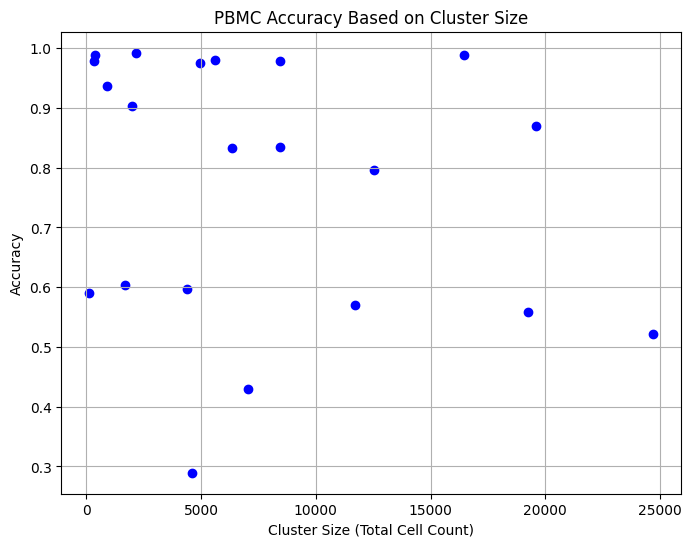

    cluster  celltype.l2  accuracy
4         0    CD14 Mono  0.988893
15        1    CD16 Mono  0.833570
24       10      B naive  0.569660
31       11    CD14 Mono  0.976037
37       12    CD14 Mono  0.977988
45       13          pDC  0.937637
49       14  Plasmablast  0.989101
50       15    CD14 Mono  0.979922
59       16         HSPC  0.978723
71       17     Platelet  0.992623
84       18        Eryth  0.589928
93       19    CD14 Mono  0.834323
106       2         cDC2  0.903808
109      20      B naive  0.603873
114       3      CD4 TCM  0.558251
134       4    CD4 Naive  0.522290
156       5      CD8 TEM  0.796998
167       6    CD8 Naive  0.289405
177       7    CD4 Naive  0.429645
197       8           NK  0.869525
208       9         MAIT  0.596359


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'cluster' and 'celltype.l2', then count the occurrences
cell_type_counts_per_cluster = cluster_cells_df.groupby(['cluster', 'celltype.l2']).size().reset_index(name='cell_count')

# Remove rows with 0 counts
cell_type_counts_per_cluster = cell_type_counts_per_cluster[cell_type_counts_per_cluster['cell_count'] > 0]

# Compute the total cell count per cluster
total_cells_per_cluster = cell_type_counts_per_cluster.groupby('cluster')['cell_count'].sum().reset_index(name='total_cell_count')

# Merge the total cell count with the cell_type_counts_per_cluster
cell_type_counts_per_cluster = cell_type_counts_per_cluster.merge(total_cells_per_cluster, on='cluster')

# Find the maximum cell count for each cluster
max_cell_counts_per_cluster = cell_type_counts_per_cluster.groupby('cluster')['cell_count'].max().reset_index(name='max_cell_count')

# Merge to get the highest count cell type and its corresponding count
max_cell_type_per_cluster = pd.merge(cell_type_counts_per_cluster, max_cell_counts_per_cluster, on='cluster')

# Filter rows where the cell_count is equal to max_cell_count
max_cell_type_per_cluster = max_cell_type_per_cluster[max_cell_type_per_cluster['cell_count'] == max_cell_type_per_cluster['max_cell_count']]

# Calculate accuracy (max_cell_count / total_cell_count)
max_cell_type_per_cluster['accuracy'] = max_cell_type_per_cluster['cell_count'] / max_cell_type_per_cluster['total_cell_count']

# Now, plot accuracy vs cluster size
plt.figure(figsize=(8, 6))
plt.scatter(max_cell_type_per_cluster['total_cell_count'], max_cell_type_per_cluster['accuracy'], color='blue')
plt.xlabel('Cluster Size (Total Cell Count)')
plt.ylabel('Accuracy')
plt.title('PBMC Accuracy Based on Cluster Size')
plt.grid(True)
plt.show()

# Display the resulting DataFrame
print(max_cell_type_per_cluster[['cluster', 'celltype.l2', 'accuracy']])

# Save the result to a CSV file
max_cell_type_per_cluster[['cluster', 'celltype.l2', 'accuracy']].to_csv('cluster_accuracy.csv', index=False)


In [2]:
import celltypist
import pandas as pd

#Turn on the majority voting classifier as well.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

NameError: name 'adata' is not defined

In [ ]:
#Examine the correspondence between CellTypist predictions (`use_as_prediction`) and manual annotations (`use_as_reference`).
#Here, `predicted_labels` from `predictions.predicted_labels` is used as the prediction result from CellTypist.
#`use_as_prediction` can be also set as `majority_voting` (see `1.7.`).
celltypist.dotplot(predictions, use_as_reference = 'column_key_of_manual_annotation', use_as_prediction = 'predicted_labels')